In [30]:
from smitebuilder.etl import get_matchdata, extract_performance_data, extract_win_label
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

In [38]:
raw_data = get_matchdata('/home/jack/pCloudDrive/SmiteData/conquest_match_data/1649.json')
data = extract_performance_data(raw_data)[:,:-1]
label = extract_win_label(raw_data).reshape(len(raw_data),)

In [5]:
two_d = TSNE().fit_transform(data)

No handles with labels found to put in legend.


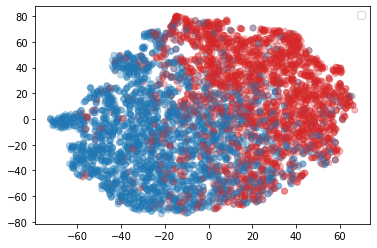

In [9]:
x = [x[0] for x in two_d]
y = [y[1] for y in two_d]
c = ['tab:blue' if e == 1 else 'tab:red' for e in label]
plt.scatter(x,y, c=c, alpha=0.3)
# plt.legend()
plt.show()

In [39]:
svm = SVC(kernel='poly', random_state=0)
svm.fit(data, label)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [40]:
new_l = svm.predict(data)
svm.score(data, label)

0.8349936605687376

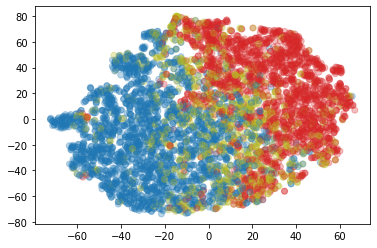

In [60]:
x = [x[0] for x in two_d]
y = [y[1] for y in two_d]
c = ['tab:blue' if e == 1 else 'tab:red' for e in new_l]
c = [e if label[idx] == new_l[idx] else 'tab:olive' for idx,e in enumerate(c)]
plt.scatter(x,y, c=c, alpha=0.3)
# plt.legend()
plt.show()

In [53]:
sgdc = SGDClassifier(random_state=0)
sgdc.fit(data, label)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [54]:
new_l = sgdc.predict(data)
sgdc.score(data,label)

0.8147074805288897

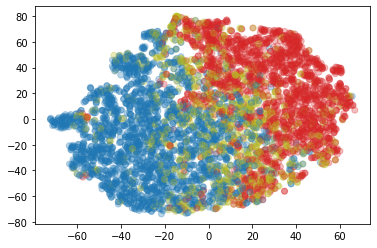

In [61]:
x = [x[0] for x in two_d]
y = [y[1] for y in two_d]
c = ['tab:blue' if e == 1 else 'tab:red' for e in new_l]
c = [e if label[idx] == new_l[idx] else 'tab:olive' for idx,e in enumerate(c)]
plt.scatter(x,y, c=c, alpha=0.3)
# plt.legend()
plt.show()

In [56]:
[x for x in sgdc.coef_[0]]

[-0.3459130374623803,
 1.1031010010632665,
 0.08661187423638037,
 0.3480802292467961,
 -0.9035189684685941,
 -0.5528189469300597,
 -1.0972756983057381,
 0.7660770291775236,
 -0.020872046894571256]

In [ ]:
x["BIAS"],
x["assists"],
x["damage_mitigated"],
x["damage_player"],
x["damage_taken"],
x["deaths"],
x["healing"],
x["healing_player_self"],
x["kills_player"],
x["structure_damage"],